# Compute the minimised free energy for a given correlation matrix
*Cyril Rommens, s12495719, masterproject MSc Physics and Astronomy: Computational Physics of Complex Systems*

**Content**
Script that takes as input the pruned correlation matrix, f.e. generated from a time series set, and gives as output:
- The subject ID
- The analytical max(S)
- The analytical min(U)
- The optimised min(F) for a range of temperatures (so a list of scalars)
- The probability distribution p for each optimised F (so a list of lists)

Note: if I want to include the pruning of the matrix, I have to give as input the original timeseries from which the correlation matrix and phase randomised can be generated, and then the pruned one consecutively.

In [289]:
# Import necessary libraries
import numpy as np
import glob
import matplotlib.pyplot as plt
import pandas as pd

# Import external background functions
%run Week_18_functions.py

In [285]:
# Import HCP data to test the script
path = glob.glob('Pruned_data_HCPAging\REST1\*.txt')

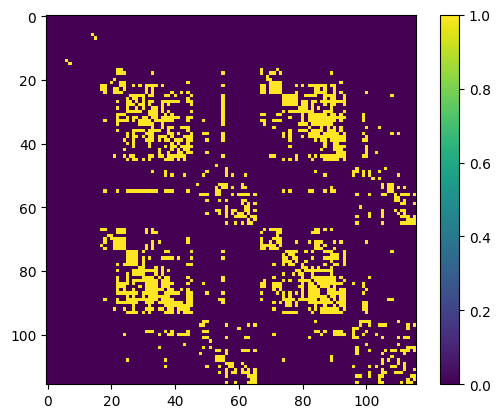

In [368]:
matrix = np.loadtxt('Cyril\prunned_matrix.txt')
matrix = matrix - np.eye(len(matrix),len(matrix))
plt.imshow(matrix)
plt.colorbar()
plt.show()

In [370]:
density = np.sum(matrix)/(len(matrix)**2)
print(f'The density of the pruned matrix is {density:.2f}')

The density of the pruned matrix is 0.11


In [ ]:
%time complete_f_generator('Cyril\prunned_matrix.txt', 3)

In [367]:
def complete_f_generator(file, max_dim):
    # Import datafile as matrix
    matrix = np.loadtxt(file)

    # Extract patient ID from filename
    identification_code = 'no HCA found'
    parts = file.split('_')
    for part in parts:
        if part.startswith("HCA"):
            identification_code = part[3:]
            break

    # Generate connection matrix and inverse
    clique_complex =  build_clique_complex(matrix, max_dim)
    matrix, inverse_connectivity_matrix = generate_inverse_connectivity_matrix(clique_complex)

    # Generate maximum shannon entropy from uniform distribution
    n = len(inverse_connectivity_matrix)
    p_Smax = np.ones(n) / n
    max_entropy_value = shannon_entropy(p_Smax)

    # Generate minimum internal energy from analytical solution
    min_energy_probabilities = (np.inner(matrix,[1]*len(matrix)))/np.sum(matrix)
    min_energy_value = energy_function(min_energy_probabilities, inverse_connectivity_matrix)

    # Generate minimum free energy by custom optimisation
    f_per_T = []
    p_per_T = []
    temperature_list = [0.5] #One temperature for now, to look at a range use here: np.arange(0, 1, 1)

    for temperature in temperature_list:
        free_energy_history, f_probabilities = free_energy_minimisation(clique_complex, inverse_connectivity_matrix, 1000, temperature)
        f_per_T.append(free_energy_history[-1])
        p_per_T.append(f_probabilities)

    return [identification_code, max_entropy_value, min_energy_value, f_per_T, p_per_T, temperature_list]

In [315]:
# Create an empty DataFrame with specified columns
df = pd.DataFrame(columns=['identification_code', 'max_entropy', 'min_energy', 'F_per_T', 'p_per_T', 'temperatures'])
max_clique_size = 3

for file in path[:5]:
    F = complete_f_generator(file, 3)
    # Append the list as a new row to the DataFrame
    df.loc[len(df)] = F

In [316]:
df

,identification_code,max_entropy,min_energy,F_per_T,p_per_T,temperatures
0,6002236,7.727920,0.000445,[-3.605230048361686],"[[0.0038152903066105766, 0.008750248076188152,...",[0.5]
1,6010538,7.781360,0.000334,[-3.618612886073435],"[[0.008451894160299072, 0.00024010290111203795...",[0.5]
2,6018857,7.768184,0.000401,[-3.6057797466705055],"[[0.009318305200515948, 0.006174028332138782, ...",[0.5]
3,6030645,7.714246,0.000512,[-3.6164519435879936],"[[0.0050151980903812236, 0.009482490728001178,...",[0.5]
4,6047359,7.727920,0.000438,[-3.6123397956186487],"[[0.002031845934579866, 0.0049611475408255865,...",[0.5]


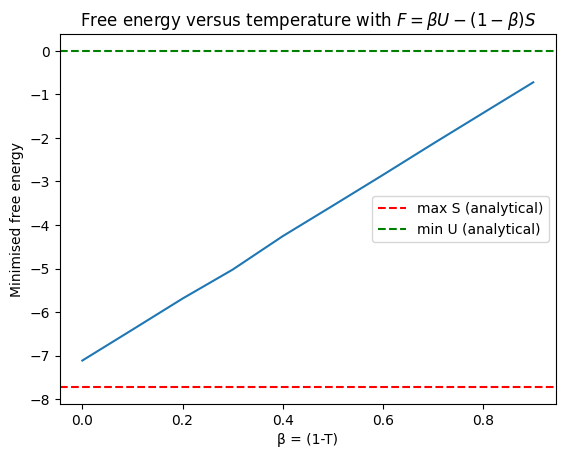

In [288]:
plt.plot(F[5], F[3])
plt.title('Free energy versus temperature with $F= β U - (1-β) S$')
plt.ylabel('Minimised free energy')
plt.xlabel('β = (1-T)')
plt.axhline(y=-F[1], color='r', linestyle='--', label='max S (analytical)')
plt.axhline(y=F[2], color='g', linestyle='--', label='min U (analytical)')
plt.legend() 
plt.show()